In [41]:
import os
import http
#import lightkurve as lk
from lightkurve import search_tesscut
from lightkurve import DesignMatrix
from lightkurve import DesignMatrixCollection
from lightkurve import RegressionCorrector
from lightkurve import LightCurve
import numpy as np
import re
import sys
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import patches
from astroquery.skyview import SkyView
from astropy.coordinates import get_icrs_coordinates
from astropy.coordinates.name_resolve import NameResolveError
from numpy.linalg import LinAlgError
from astropy.coordinates import SkyCoord
from astropy.wcs import *
from astropy import units as u
import astropy.io.fits as pyfits
from io import StringIO
import math
from astroquery.simbad import Simbad
plt.ion()

primary_correction_method = 3
tpf_width_height = 30
additive_pca_num = 3
multiplicative_pca_num = 3
pca_only_num = 3
lowest_dss_contour = 0.5 
sys_threshold_orig = 0.2
max_masked_regions = 30
#plot_index_init = 300
plot_index_fraction = 0.3
bf_threshold = 1.5 
prop_error_flag = True

#vvv
#aperture
pixel_threshold_orig = 2.2 #times the background flux (for background_percentile = 10, 2.4 for 20?)
int_pixel_threshold_orig = 2.2 #same but for integrated flux instead of at plot_index
background_percentile_orig = 10 #percentile determining background for pixel threshold
decrease_pixel_threshold = 0.05 #reduce pixel threshold by this if central pixel is already below threshold
decrease_int_pixel_threshold = 0.05 #same for integrated flux
shift_plot_index = 50 #shift index by this if there are zero or negative flux values
endlength = 200 #usual length of systematics at the end
adjacent_ratio_threshold = 1.5 #ratio of bridge pixel flux to adjacent pixel flux, rejected if higher
fraction_of_central = 1/2 #for gradients in galaxy: include pixels with adjacent pixel above this fraction
max_aperture_fraction = 1/6 #maximum fraction of the tpf that can be part of the aperture
tpf_size_large = 50 #new tpf_width_height if aperture has too many pixels
tpf_size_huge = 99 #next tpf_width_height if aperture still has too many pixels
shift_background_percentile = 5 #shift background percentile by this if threshold is negative
max_background_percentile = 20 #maximum allowed percentile for background
extension_threshold = 9 #minimum aperture to reject single-pixel width extensions

#mask
#maskout_threshold = 20 #times the mean absolute value of the additive component
#maskend_threshold = 0.8 #fraction of sys_threshold determining end of a mask
min_bkg_length = 2/3 #acceptable unmasked fraction of the background before starting with new sys_threshold
increase_sys_threshold = 0.05 #increase sys_threshold by this when too much was masked out
min_mask_gap = 10 #gaps smaller than this between values above sys_threshold are included in masks
maskextension = 2 #number of timesteps added before and after each mask
spiky_width = 3 #maximum width of spiky systematics for findspiky
sys_onestep = 0.1 #mask out if sudden jump in principal component is at least this high
maskwidth_jump = 3 #mask out at most this many extra steps before/after a sudden jump
min_tpf_length = 0.5 #maximum fraction of the tpf that can be rejected due to nans or all zeros
        
#for masking out regions, arbitrary threshold
def maskoutonce(bkg): #only goes through bkg once, cannot create masks backward
    mask = []
    if len(bkg) > 0:
#        absum = sum(abs(x) for x in bkg)
#        mean = absum / len(bkg)
#        print('mean:',mean)
        for t, timestep in enumerate(bkg):
            if abs(timestep) > sys_threshold: #mean * 20:
                if len(masked_cadence_limits) > 1:
                    if t > masked_cadence_limits[-1]:
#                if len(masked_cadence_limits) > 1 and t - masked_cadence_limits[-1] < 5:
#                    mask = mask[:-1]
#                    print('popped')
                        mask.append(t-maskextension)
                        break
                else: #indent one further if not allowing multiple masks for same region
                    mask.append(t-maskextension)
#                    print('first exceeding:',timestep,'at t =',t)
                    break
        if len(mask) > 0:
            for z, timestep in enumerate(bkg[mask[0]:], start=mask[0]):
                if abs(timestep) <= sys_threshold * maskend_threshold: #mean * 10:
                    mask.append(z+maskextension-1)
                    break
        if len(mask) == 1:
            mask.append(len(bkg))
#        if len(mask) == 2:
#            bkg[mask[0]:mask[1]] = 0
        if len(mask) == 2: #extend mask if systematics a few steps further
            for y, timestep in enumerate(bkg[mask[1]:mask[1] + min_mask_gap], start=mask[1]): #check for systematics in next timesteps
                if abs(timestep) > sys_threshold:
                    for x, timestep2 in enumerate(bkg[y:], start=y): # +3 each
                        if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                            mask[1] = x+maskextension-1 #change end to end of next mask
                            break
        return mask

def maskout(bkg): #create masks wherever additive_bkg is too high
    mask = []
    if len(bkg) > 0:
        for t, timestep in enumerate(bkg):
            if abs(timestep) > sys_threshold: #mean * 20:
                mask.append(t-maskextension) #beginning of systematics
                break
        if len(mask) > 0:
            for z, timestep in enumerate(bkg[mask[0]+maskextension+1:], start=mask[0]+maskextension+1): # +3 each
                if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                    mask.append(z+maskextension-1) #end of systematics (below sys times maskout threshold)
                    #print('z =',z)
                    break
        if len(mask) == 2: #extend mask if systematics a few steps further
            for y, timestep in enumerate(bkg[mask[1]:mask[1] + min_mask_gap], start=mask[1]): #check for systematics in next timesteps
                if abs(timestep) > sys_threshold:
                    for x, timestep2 in enumerate(bkg[y:], start=y): # +3 each
                        if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                            mask[1] = x+maskextension-1 #change end to end of next mask
                            #print('x =',x)
                            break
        if len(mask) == 1: #systematics until the very end
            mask.append(len(bkg))
        #print(mask)
        return mask
    
def maskout_once(bkg): 
    mask = []
    if len(bkg) > 0:
        if abs(bkg[0]) > sys_threshold: #systematics at the beginning
            for t, timestep in enumerate(bkg[1:]):
                if abs(timestep) < sys_threshold:
                    mask.append([0,t+maskextension-1])
                    break 
        for t, timestep in enumerate(bkg[1:],start=1):
            maskregion = []
            if abs(timestep) > sys_threshold and abs(bkg[t-1]) <= sys_threshold:
                maskregion.append(t-maskextension) 
                for z, timestep in enumerate(bkg[t+1:], start=t+1):
                    if abs(timestep) < sys_threshold:
                        maskregion.append(z+maskextension-1)
                        mask.append(maskregion)
                        break
        if len(maskregion) > 0: #systematics until the end
            maskregion.append(len(bkg)-1)
            mask.append(maskregion)     
    delete = []
    if len(mask) > 1: #merge masks that are close together
        for j,i in enumerate(mask[1:]):
            if i[0] - mask[j][1] <= min_mask_gap:
                mask[j][1] = i[1]
                delete.append(j+1)
    mask = [masknr for index, masknr in enumerate(mask) if index not in delete]
    return mask
    
def findspiky(bkg): #only masks out systematics that are narrow
    mask = []
    if len(bkg) > 0:
        if abs(bkg[0]) > sys_threshold: #spiky systematics at the beginning
            for t, timestep in enumerate(bkg[1:1+spiky_width*cadencefactor]):
                if abs(timestep) < sys_threshold:
                    mask.append([0,t+maskextension-1])
                    break 
        for t, timestep in enumerate(bkg[1:],start=1):
            maskregion = []
            if abs(timestep) > sys_threshold and abs(bkg[t-1]) <= sys_threshold:
                if any(abs(value) < sys_threshold for value in bkg[t+1:t+spiky_width*cadencefactor+1]):
                    maskregion.append(t-maskextension)
                    for z, timestep in enumerate(bkg[t+1:t+1+spiky_width*cadencefactor], start=t+1):
                        if abs(timestep) < sys_threshold: # and 1 <= z-t <= spiky_width*cadencefactor
                            maskregion.append(z+maskextension-1) #end of spiky systematics
                            break
                elif abs(bkg[t-1] - timestep) >= sys_onestep: #sudden jump up in PC
                    maskregion.append(t-maskextension)
                    for z, timestep in enumerate(bkg[t+1:t+1+maskwidth_jump*cadencefactor], start=t+1):
                        if abs(timestep) < sys_threshold:
                            maskregion.append(z+maskextension-1)
                            break
                    else:
                        maskregion.append(t+maskwidth_jump*cadencefactor+maskextension-1)
                mask.append(maskregion)
            if abs(timestep) < sys_threshold and abs(bkg[t-1] - timestep) >= sys_onestep:  #sudden jump down in PC
                maskregion.append(t+maskextension-1)
                for z, timestep in enumerate(reversed(bkg[t-1-maskwidth_jump*cadencefactor:t-1])):
                    if abs(timestep) < sys_threshold:
                        maskregion.insert(0,t-z-maskextension)
                        break
                else:
                    maskregion.insert(0,t-maskwidth_jump*cadencefactor-maskextension)
                mask.append(maskregion)
        if abs(bkg[-1]) > sys_threshold: #spiky systematics until the very end
            for t, timestep in enumerate(reversed(bkg[-1-spiky_width*cadencefactor:-1])):
                if abs(timestep) < sys_threshold:
                    mask.append([len(bkg)-t-maskextension,len(bkg)-1])
                    break            
    if mask:
        mask.sort(key=lambda interval: interval[0])
        merged = [mask[0]]
        for spike in mask:
            previous = merged[-1]
            if spike[0] <= previous[1]+1:
                previous[1] = max(previous[1], spike[1])
            else:
                merged.append(spike)
        mask = merged       
    """for s,spike in enumerate(mask[1:],start=1):
            if spike[0] <= mask[s-1][1]:
                print(mask)
                mask[s-1:s+1] = [[mask[s-1][0],mask[s][1]]]
                print(s)
                print([[mask[s-1][0],mask[s][1]]])"""
    return mask

def findswoopy(bkg):
    mask_swoopy = []
    if len(bkg) > 0:
        i = 0
        while i < len(bkg):
            maskregion = []
            if abs(bkg[i]) > sys_threshold:
                if not any(abs(value) < sys_threshold for value in bkg[i+1:i+spiky_width*cadencefactor+1]):
                    maskregion.append(i)
                    for z, timestep in enumerate(bkg[i+1:], start=i+1):
                        if abs(timestep) < sys_threshold:
                            maskregion.append(z)
                            mask_swoopy.append(maskregion)
                            i = z + 1
                            break
            i += 1
        if len(maskregion) == 1:
            maskregion.append(len(bkg)-1)
            mask_swoopy.append(maskregion)
    return mask_swoopy
#^^^
    
# Define function for stitching the sectors together once corrected:
def lc_stitch(unstitched_lc):
    for j in range(0,len(unstitched_lc)):
        if j!=0:
            sector = str(j+1)
        lc = unstitched_lc[j]
        t = lc[:,0]
        f = lc[:,1]
        err = lc[:,2]
        if j == 0:
            full_lc_time = t
            full_lc_flux = f
            full_lc_err= err
        else:
            first_flux = np.mean(f[:10])
            last_flux = np.mean(full_lc_flux[-10:])
            scale_factor= first_flux - last_flux
            if scale_factor > 0:
                scaled_flux = f - abs(scale_factor)
            if scale_factor < 0:
                scaled_flux = f + abs(scale_factor)
            full_lc_time = np.append(full_lc_time,t)
            full_lc_flux = np.append(full_lc_flux,scaled_flux)
            full_lc_err = np.append(full_lc_err,err)
    return full_lc_time,full_lc_flux,full_lc_err

# Define function to remove single-cadence jumps of greater or lesser than 1% of the flux on either side.
def remove_jumps(t,f,err):
    for i in range(0,1-len(t)):
        if i !=0 and i != len(f)-1 and f[i] > (0.01 * f[i-1]+f[i-1]) and f[i] > (0.01 * f[i+1] + f[i+1]):
            t = np.delete(t,i)
            f = np.delete(f,i)
            err = np.delete(err,i)
    for i in range(0,1-len(t)):
        if i !=0 and i != len(f)-1 and f[i] < (f[i-1] - 0.01 * f[i-1]) and f[i] < (f[i+1]-0.01 * f[i+1]):
            t = np.delete(t,i)
            f = np.delete(f,i)
            err = np.delete(err,i)
    return t,f,err


######## BEGIN MAIN PROGRAM ########
#Define target and obtain DSS image from common name or coordinates.

start


Now investigating target NGC 3672 

<SkyCoord (ICRS): (ra, dec) in deg
    (171.26034351, -9.79537787)>
observed sectors for NGC 3672 : [9, 36, 63, 72]
majaxis = 2.283 ' ; minaxis = 0.959 '
diameter = 1.621000051498413 '
length: 29 pixels

starting analysis

Generating pixel map for sector 9.
Removed 8 cadences due to nan values or all zero pixel fluxes.

starting from scratch
initial bkg length: 1127
first masked region: [0, 3]
len(additive_bkg.values) = 1127
masks: [[564, 572], []]
intervals: [[564, 572]]
masked out [564, 572]
len(additive_bkg.values) = 1114 / 1127
masks: [[-2, 6], []]
intervals: [[-2, 6]]
masked out [-2, 6]
len(additive_bkg.values) = 1107 / 1127
masks: [[-2, 2], []]
intervals: [[-2, 2]]
masked out [-2, 2]
len(additive_bkg.values) = 1104 / 1127
masks: [[552, 562], []]
intervals: [[552, 562]]
masked out [552, 562]
len(additive_bkg.values) = 1093 / 1127
masks: [[-2, 5], []]
intervals: [[-2, 5]]
masked out [-2, 5]
len(additive_bkg.values) = 1087 / 1127
masks: [[

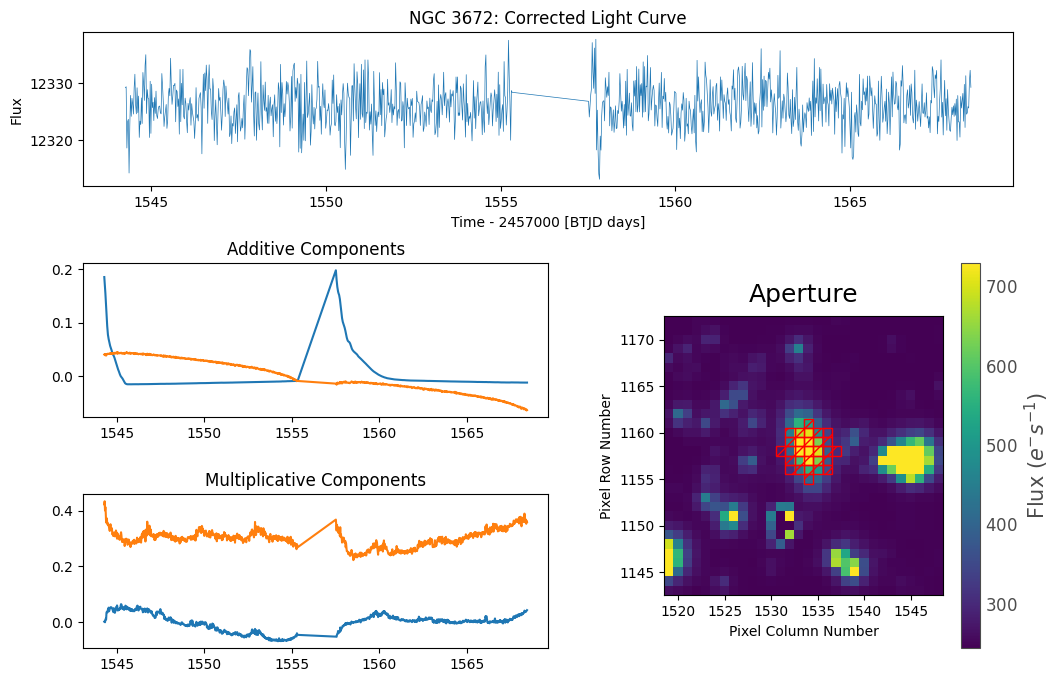

Sector, CCD, camera: 
9 3 1


Over- and underfitting metrics: 
Full hybrid overfit: 0.7385738459323045
Simple hybrid overfit: 0.8454688099541818
Simple PCA overfit: 0.625921560784807

Moving to next sector.



NameError: name 'SearchError' is not defined

In [43]:
#vvv
#sys.stdout = original_stdout
print('start')

#with open('targets/targetlist quaver elk radius.txt', 'r') as file:
#    lines = file.readlines()
lines = ["NGC 3672"]

for j,i in enumerate(lines):
        #to save printed outputs to a file
    #original_stdout = sys.stdout 
    """with open('text.txt', 'w') as f:
        sys.stdout = f#"""
    """sys.stdout = StringIO()  # Redirect to a variable
    tee_output = sys.stdout #"""
    target = i.strip()
    target = target.replace("Ã¢â‚¬â€œ", "-")
    target_safename = target.replace(" ","")
    directory = f'quaver_output/quaver diameter/{target_safename}'
    print("\n\nNow investigating target", target,'\n')
    if not os.path.exists(directory):
        os.makedirs(directory)
    #sys.stdout = original_stdout
    #sys.stdout = open('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_info.txt', 'w')
    
    try:
#^^^
        target_coordinates = target
        source_coordinates = get_icrs_coordinates(target)       #this requires that SIMBAD be up and working...
        print(source_coordinates)
        #print("\n")
    except NameResolveError:
        print('\n\n',target,"not found. Move to next object.\n\n")
        #sys.stdout = original_stdout
        continue

    try:
        dss_image = SkyView.get_images(position=source_coordinates,survey='DSS',pixels=str(400))
        wcs_dss = WCS(dss_image[0][0].header)
        dss_pixmin = np.min(dss_image[0][0].data)
        dss_pixmax = np.max(dss_image[0][0].data)
        dss_pixmean = np.mean(dss_image[0][0].data)
        dss_head = dss_image[0][0].header
        dss_ra = dss_head['CRVAL1']
        dss_dec = dss_head['CRVAL2']
    except IndexError:
        dss_image = SkyView.get_images(position=source_coordinates,survey='TESS',pixels=str(400))
        wcs_dss = WCS(dss_image[0][0].header)
        dss_pixmin = np.min(dss_image[0][0].data)
        dss_pixmax = np.max(dss_image[0][0].data)
        dss_pixmean = np.mean(dss_image[0][0].data)
        dss_head = dss_image[0][0].header
        dss_ra = dss_head['CRVAL1']
        dss_dec = dss_head['CRVAL2']
        print('IndexError! Use TESS survey instead of DSS for contours.')

    #Retrieve the available tesscut data for FFI-only targets.
    sector_data = search_tesscut(target_coordinates)
    num_obs_sectors = len(sector_data)
    if num_obs_sectors == 0:
        print("This object has not been observed by TESS.")
        #sys.exit()
        continue

    list_observed_sectors = []
    #list_observed_sectors_in_cycle = []
    #list_sectordata_index_in_cycle = []
    for i in range(0,len(sector_data)):
        sector_number = int(sector_data[i].mission[0][12:14])       #This will need to change, Y2K style, if TESS ever has more than 100 sectors.
        list_observed_sectors.append(sector_number)

#vvv
    list_observed_sectors.sort()
    sectors_cyc1 = [sec for sec in list_observed_sectors if sec <= 13]
    sectors_cyc2 = [sec for sec in list_observed_sectors if 14 <= sec <= 26]
    sectors_cyc3 = [sec for sec in list_observed_sectors if 27 <= sec <= 39]
    sectors_cyc4 = [sec for sec in list_observed_sectors if 40 <= sec <= 55]
    sectors_cyc5 = [sec for sec in list_observed_sectors if 56 <= sec <= 69]
    sectors_cyc6 = [sec for sec in list_observed_sectors if 70 <= sec]
    print('observed sectors for',target.strip(),':',list_observed_sectors)

    try:
        customSimbad = Simbad()
        customSimbad.add_votable_fields('dimensions')
        result = customSimbad.query_object(target)
        try:
            majaxis = result['GALDIM_MAJAXIS']
            minaxis = result['GALDIM_MINAXIS']
        except KeyError:
            print('KeyError when trying to access diameter')
            continue
        if (majaxis is None or not isinstance(majaxis[0], (int, float, np.float32))) and (minaxis is None or not isinstance(minaxis[0], (int, float, np.float32))):
            print('no diameter found, skip this object')
            continue
        elif (majaxis is None or not isinstance(majaxis[0], (int, float, np.float32))) and (minaxis is not None and isinstance(minaxis[0], (int, float, np.float32))):
            diameter = minaxis[0]
            print("diameter = minaxis =", diameter, "'")
        elif (majaxis is not None and isinstance(majaxis[0], (int, float, np.float32))) and (minaxis is None or not isinstance(minaxis[0], (int, float, np.float32))):
            diameter = majaxis[0]
            print("diameter = majaxis =", diameter, "'")
        else:
            diameter = (majaxis[0] + minaxis[0]) / 2
            print('majaxis =',majaxis[0],"' ; minaxis =",minaxis[0],"'")
            print("diameter =", diameter, "'")
    except TypeError:
        print('no diameter found, skip this object')
        continue 

    if diameter <= 8.8:
        tpf_width_height = 30
    elif diameter <= 15.9:
        tpf_width_height = 50
    elif diameter <= 23.0:
        tpf_width_height = 70
    elif diameter <= 34.2:
        tpf_width_height = 99
    else:
        print('Radius too big! Skip this object.')
        #sys.stdout = original_stdout
        continue
    central = tpf_width_height // 2
    row_col_coords = []
    pixels_radius = diameter * 60 / 21.2 / 2
    radius_rounded = math.ceil(pixels_radius)
    for m in range(tpf_width_height):
        for n in range(tpf_width_height):
            distance = math.sqrt((m - central)**2 + (n - central)**2)
            if distance <= radius_rounded:
                row_col_coords.append((m,n))
    #print('aperture mask:', row_col_coords)
    print('length:',len(row_col_coords),'pixels')
#^^^

    print('\nstarting analysis')
    #If object is observed by TESS and specified Cycle makes sense, begin aperture selection and extraction!

    #vvv    
    unstitched_lc_pca_cyc1 = []
    unstitched_lc_simple_hyb_cyc1 = []
    unstitched_lc_full_hyb_cyc1 = []
    unstitched_lc_pca_cyc2 = []
    unstitched_lc_simple_hyb_cyc2 = []
    unstitched_lc_full_hyb_cyc2 = []
    unstitched_lc_pca_cyc3 = []
    unstitched_lc_simple_hyb_cyc3 = []
    unstitched_lc_full_hyb_cyc3 = []
    unstitched_lc_pca_cyc4 = []
    unstitched_lc_simple_hyb_cyc4 = []
    unstitched_lc_full_hyb_cyc4 = []
    unstitched_lc_pca_cyc5 = []
    unstitched_lc_simple_hyb_cyc5 = []
    unstitched_lc_full_hyb_cyc5 = []
    unstitched_lc_pca_cyc6 = []
    unstitched_lc_simple_hyb_cyc6 = []
    unstitched_lc_full_hyb_cyc6 = []

    #sys.stdout = original_stdout
    #for current_sector in range(0,1):
    for current_sector in range(len(list_observed_sectors)):
        try:
    #^^^
            tpf = sector_data[current_sector].download(cutout_size=(tpf_width_height, tpf_width_height)) #gets earliest sector
    #vvv
        except SearchError:
            print('\n\nSearchError for',target,': Unable to download FFI cutout. Desired target coordinates may be too near the edge of the FFI. Move to next object.\n\n')
            #sys.stdout = original_stdout
            continue
            
        plot_index = round(len(tpf.flux) * plot_index_fraction)
        central = tpf_width_height // 2
        if current_sector <= 26:
            cadencefactor = 1
        elif current_sector <= 55:
            cadencefactor = 3
        else:
            cadencefactor = 9
            
        #instead of loop:
        orig_length = len(tpf)
        tpf = tpf[~np.isnan(tpf.flux).any(axis=(1,2)) & ~(tpf.flux == 0).all(axis=(1,2))]
        length = len(tpf)
    #^^^
        sector_number = tpf.get_header()['SECTOR']
        sec = str(sector_number)
        ccd = tpf.get_header()['CCD']
        cam = tpf.get_header()['CAMERA']
    #vvv
        #sys.stdout = open('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_info_'+sec+'.txt', 'w')
        if length < orig_length * min_tpf_length:
            print('Too many cadences have NaNs or are all zero (',orig_length-length,'of',orig_length,'). Skip this sector.')
            continue
    #^^^
        print("\nGenerating pixel map for sector "+sec+".")

        #Check that this object is actually on silicon and getting data (not always the case just because TESSCut says so).
        #By making a light curve from a dummy aperture of the middle 5x5 square and seeing if its mean flux is zero.
        aper_dummy = np.zeros(tpf[0].shape[1:], dtype=bool) #blank
        aper_dummy[int(tpf_width_height/2-3):int(tpf_width_height/2+3),int(tpf_width_height/2-3):int(tpf_width_height/2+3)] = True
        lc_dummy = tpf.to_lightcurve(aperture_mask=aper_dummy)

        if np.mean(lc_dummy.flux) == 0:
            print("This object is not actually on silicon.")
            #sys.ext()
            #continue
            break
        else:
            hdu = tpf.get_header(ext=2)
            #Get WCS information and flux stats of the TPF image.
            tpf_wcs = WCS(tpf.get_header(ext=2))
            pixmin = np.min(tpf.flux[plot_index]).value
        #vvv
            if orig_length != length:
                print('Removed',orig_length-length,'cadences due to nan values or all zero pixel fluxes.')
            if tpf.flux[plot_index].value[central][central] <= 0:
                while plot_index < length - endlength:
                    plot_index += shift_plot_index
                    print('Central pixel has zero or negative flux value (',tpf.flux[plot_index].value[central][central],')! Now trying index',plot_index,'.')
                    #print('There are negative or zero flux values (pixmin =',pixmin_init,')! \nNow trying index',plot_index,'.')
                    central_pixel_flux = tpf.flux[plot_index].value[central][central]
                    if central_pixel_flux > 0:
                        print('Flux is',central_pixel_flux,'at plot index',plot_index,'. Use this now.')
                        break
                if central_pixel_flux < 0:
                    #pixmin = np.min(x for x in tpf.flux[plot_index_init] if x > 0).value
                    #print('Could not find index without negative or zero flux values. Instead use smallest nonzero absolute value at index',plot_index_init,'. Resulting aperture might not be reasonable.')   
                    print('Central pixel flux negative at all tested plot indices. Skip this sector.')
                    #continue
                    break #due to insertd while loop
                elif central_pixel_flux == 0:
                    print('Central pixel flux zero at all tested plot indices. Skip this sector.')
                    #continue
                    break
        #^^^
            pixmax = np.max(tpf.flux[plot_index]).value
            pixmean = np.mean(tpf.flux[plot_index]).value
            temp_min = float(pixmin)
            # print(temp_min)
            temp_max = float(1e-3*pixmax+pixmean)
            #temp_max = pixmax
            # print(temp_max)
            #Create a blank boolean array for the aperture, which will turn to TRUE when pixels are selected.
            aper = np.zeros(tpf[0].shape[1:], dtype=bool) #blank
            aper_mod = aper.copy() #For the source aperture
            aper_buffer = aper.copy()    #For the source aperture plus a buffer region to exclude from both additive and mult. regressors
            aper_width = tpf[0].shape[1]

        #vvv
            #threshold = pixmin * pixel_threshold
            central = tpf_width_height // 2
            background_percentile = background_percentile_orig
            pixel_threshold = pixel_threshold_orig
            int_pixel_threshold = int_pixel_threshold_orig
            integrated_flux = np.sum(tpf.flux.value, axis=0)
                #sometimes better to use tpf.flux[plot_index].value instead of background_flux?
            background_flux = np.nanpercentile(tpf.flux[plot_index].value, background_percentile)
            int_background_flux = np.nanpercentile(integrated_flux, background_percentile)
            
            flux_flat = np.array(tpf.flux.value).flatten()
            integrated_flux_flat = np.array(integrated_flux).flatten()
            flux_nans = np.isnan(flux_flat).sum()
            int_flux_nans = np.isnan(integrated_flux_flat).sum()
            if flux_nans > 0 or int_flux_nans > 0:
                print('nan values in background!')
                print(flux_nans,'in background flux,',int_flux_nans,'in integrated background flux')
                if int_flux_nans >= tpf_width_height**2*background_percentile/100:
                    print('That is too many! Skip this sector.')
                    break
                    
            threshold = background_flux * pixel_threshold
            int_threshold = int_background_flux * int_pixel_threshold
            if threshold <= 0 or int_threshold <= 0:
                while background_percentile <= max_background_percentile:
                    print('Negative threshold! Background flux =',background_flux,', integrated background flux =',int_background_flux)
                    print('Try with background_percentile =',background_percentile)
                    background_flux = np.nanpercentile(tpf.flux[plot_index].value, background_percentile)
                    int_background_flux = np.nanpercentile(integrated_flux, background_percentile)
                    background_percentile += shift_background_percentile
                    if background_flux > 0 and int_background_flux > 0:
                        break
                else:
                    print('Reached max background percentile, threshold still negative (background_flux =',background_flux,'; int_background_flux =',int_background_flux,').')
                    print('Skip this sector.')
                    break

        #^^^
            #Plot the TPF image and the DSS contours together, to help with aperture selection, along with the starter aperture.
            if lowest_dss_contour == 0.4:
                dss_levels = [0.4*dss_pixmax,0.5*dss_pixmax,0.75*dss_pixmax]
            elif lowest_dss_contour < 0.4:
                dss_levels = [lowest_dss_contour*dss_pixmax,0.4*dss_pixmax,0.5*dss_pixmax,0.75*dss_pixmax]
            elif lowest_dss_contour > 0.4:
                dss_levels = [lowest_dss_contour*dss_pixmax,0.65*dss_pixmax,0.85*dss_pixmax]
            fig = plt.figure(figsize=(6,6))
            ax = fig.add_subplot(111,projection=tpf_wcs)
            # ax.imshow(tpf.flux[200],vmin=pixmin,vmax=1e-3*pixmax+pixmean)
            ax.imshow(tpf.flux[plot_index].value,vmin=temp_min,vmax=temp_max)
            ax.contour(dss_image[0][0].data,transform=ax.get_transform(wcs_dss),levels=dss_levels,colors='white',alpha=0.9)
            for pixel in row_col_coords:
                ax.scatter(pixel[0], pixel[1], marker='x', color='red', s=30)
            ax.scatter(aper_width/2.0,aper_width/2.0,marker='x',color='k',s=8)
            ax.set_xlim(-0.5,aper_width-0.5)  #This section is needed to fix the stupid plotting issue in Python 3.
            ax.set_ylim(-0.5,aper_width-0.5)
            directory = str(target).replace(" ","")   
            plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_TPF_sector_'+sec+'.pdf',format='pdf')

#            fig.canvas.mpl_disconnect(cid)
            buffer_pixels = [] #Define the buffer pixel region.

            if len(row_col_coords) == 0:
                print('No mask selected; skipping this Sector.')
            else:
                for i in range(0,len(row_col_coords)):
                    aper_mod[row_col_coords[i]] = True
                    row_same_up_column = (row_col_coords[i][0],row_col_coords[i][1]+1)
                    row_same_down_column = (row_col_coords[i][0],row_col_coords[i][1]-1)
                    column_same_down_row = (row_col_coords[i][0]-1,row_col_coords[i][1])
                    column_same_up_row = (row_col_coords[i][0]+1,row_col_coords[i][1])
                    bottom_left_corner = (row_col_coords[i][0]-1,row_col_coords[i][1]-1)
                    top_right_corner = (row_col_coords[i][0]+1,row_col_coords[i][1]+1)
                    top_left_corner = (row_col_coords[i][0]+1,row_col_coords[i][1]-1)
                    bottom_right_corner = (row_col_coords[i][0]-1,row_col_coords[i][1]+1)
                    buffer_line = (row_same_up_column,row_same_down_column,column_same_up_row,column_same_down_row,top_left_corner,top_right_corner,bottom_left_corner,bottom_right_corner)
                    buffer_pixels.append(buffer_line)
                    for coord_set in buffer_line:
                        aper_buffer[coord_set[0],coord_set[1]]=True

                #Create a mask that finds all of the bright, source-containing regions of the TPF.
                allbright_mask = tpf.create_threshold_mask(threshold=bf_threshold,reference_pixel=None)
                allfaint_mask = ~allbright_mask
                allbright_mask &= ~aper_buffer
                allfaint_mask &= ~aper_buffer

                #takes forever for small cadences!
                """#Remove any empty flux arrays from the downloaded TPF before we even get started:
                boolean_orignans = []
                for i in range(0,length):
                    #print(i)
                    if np.sum(tpf.flux[i] == 0) or np.isnan(np.sum(tpf.flux[i])) == True:
                    """"""if (tpf.flux[i][central][central] == 0 and 
                        tpf.flux[i][central//2][central//2] == 0 and 
                        tpf.flux[i][central//2][central//2*3] == 0 and
                        tpf.flux[i][central//2*3][central//2] == 0 and
                        tpf.flux[i][central//2*3][central//2*3] == 0) or \
                        np.isnan(tpf.flux[i][central][central]) == True:"""""""
                        nanflag = True
                    else:
                        nanflag = False
                    boolean_orignans.append(nanflag)
                boolean_orignans_array = np.array(boolean_orignans)
                tpf = tpf[~boolean_orignans_array] #"""
        #vvv                
                tpf_orig = tpf
                bkg_long_enough = True
                reached_end = False
                sys_threshold = sys_threshold_orig
              
                redo = True
                additive_pca_num = 2
                multiplicative_pca_num = 2
                pca_only_num = 2
                try:
                    while redo:
                        redo = False

                        while bkg_long_enough:
                            number_masked_regions = 0
                            tpf = tpf_orig
                            print('\nstarting from scratch')
        #^^^
                            #Get the additive background first:
                            additive_hybrid_pcas = additive_pca_num
                            additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                                #DesignMatrix(tpf.flux[np.nonzero(tpf.flux)])
                            additive_bkg_and_constant = additive_bkg.append_constant()
                    #vvv
                            initial_bkg_length = len(additive_bkg.values)
                            print('initial bkg length:',initial_bkg_length)
                    #^^^
                            #Add a module to catch possible major systematics that need to be masked out before continuuing:
                            if np.max(np.abs(additive_bkg.values)) > sys_threshold:   #None of the normally extracted objects has additive components with absolute values over 0.2 ish.
                    #vvv
                                masked_cadence_limits = []
                                bkg_all = [[time[i] for time in additive_bkg.values] for i in range(additive_pca_num)]
                                #masks = [findspiky(bkg) for bkg in bkg_all]
                                #masks = [maskout_once(bkg) for bkg in bkg_all]
                                masks = [maskout(bkg) for bkg in bkg_all]
                                
                                    #replace values < 0 and > len(bkg)
                                #masks = [[0 if y < 0 else len(bkg) if y > len(bkg) else y for y in s] if isinstance(s, list) else 0 if s < 0 else len(bkg) if s > len(bkg) else s for s in masks]
                                #masks = [[[0 if cadence < 0 else length-1 if cadence >= length else cadence for cadence in mask] for mask in components] for components in masks]
                                masks = [[[0 if cadence < 0 else length-1 if cadence >= length else cadence for cadence in mask] if isinstance(mask, list) else max(0, min(mask, length-1)) for mask in components] if isinstance(components, list) else max(0, min(components, length-1)) for components in masks]
                                #print('masks:',masks)
                                """if any(masks):
                                    allmasks = [item for sublist in masks for item in sublist]
                                    allmasks.sort(key=lambda interval: interval[0])
                                    intervals = [allmasks[0]]
                                    for mask in allmasks:
                                        previous = intervals[-1]
                                        if mask[0] <= previous[1]+1:
                                            previous[1] = max(previous[1], mask[1])
                                        else:
                                             intervals.append(mask)
                                    masked_cadence_limits = intervals[0] #"""
                                maskbegs = [lst[0] for lst in masks if lst]
                                masked_cadence_limits = []

                                if len(maskbegs) > 0: #""" if spiky or once
                                    masked_cadence_limits.append(min(maskbegs))
                                    intervals = sorted([interval for lst in masks if lst for interval in [lst[i:i+2] for i in range(0, len(lst), 2)]], key=lambda x: x[1])
                                    maskend = intervals[0][1]
                                    for i in range(1,additive_pca_num):
                                        if len(intervals) > i:
                                            if intervals[i][0] < maskend:
                                                 maskend = intervals[i][1]
                                    masked_cadence_limits.append(maskend)
                                    print('first masked region:',masked_cadence_limits)
                                    print('len(additive_bkg.values) =',len(additive_bkg.values)) #""" end if spiky or once
        #                        print(masked_cadence_limits)
        #                        np.savetxt('PCAs before mask.txt',bkg_all)
                    #^^^
                                   #if len(masked_cadence_limits) != 0:
                                    if masked_cadence_limits[0] >= 0:
                                        first_timestamp = tpf.time[masked_cadence_limits[0]].value
                                    else:
                                        first_timestamp = 0
                                    if masked_cadence_limits[1] < len(tpf.time) -1:
                                        last_timestamp = tpf.time[masked_cadence_limits[1]].value
                                    else:
                                        last_timestamp = tpf.time[-1].value
                                    cadence_mask = ~((tpf.time.value >= first_timestamp) & (tpf.time.value <= last_timestamp))
                                    tpf = tpf[cadence_mask]
                                    additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                                    additive_bkg_and_constant = additive_bkg.append_constant()
        #                            print(np.max(np.abs(additive_bkg.values)))

                                #vvv
                                    #for i in range(0,max_masked_regions):
                                    number_masked_regions = 1 #set to 1 at first, for this mask.
                                    while np.max(np.abs(additive_bkg.values)) > sys_threshold:
                                        """if len(intervals) == 1:
                                            reached_end = True
                                            break#""" #only one of the orincipal components has systematics left
        #                                print(np.max(np.abs(additive_bkg.values)))

                                        bkg_all = [[time[i] for time in additive_bkg.values] for i in range(additive_pca_num)]
                                        #print('masks:',masks)
                                        """for number_masked_regions in range(2,len(intervals)+1):
                                            masked_cadence_limits = intervals[number_masked_regions-1]""" #only for maskout one iteration (indent until if bkg_long_enough == False:)
                                        masked_cadence_limits = [] #only for maskout multiple iterations
                                        masks = [maskout(bkg) for bkg in bkg_all] #only for maskout multiple iterations
                                        print('masks:',masks)
                                        maskbegs = [lst[0] for lst in masks if lst] #""" if spiky or once
                                        if len(maskbegs) > 0:
                                            number_masked_regions += 1
        #                                    print('Systematics remain; define the next masked region.')
                                            masked_cadence_limits.append(min(maskbegs))
                                            intervals = sorted([interval for lst in masks if lst for interval in [lst[i:i+2] for i in range(0, len(lst), 2)]], key=lambda x: x[1])
                                            print('intervals:',intervals)
                                            maskend = intervals[0][1]
                                            for i in range(1,additive_pca_num):
                                               if len(intervals) > i:
                                                    if intervals[i][0] < maskend:
                                                          maskend = intervals[i][1]
                                            masked_cadence_limits.append(maskend) #""" end if spiky or end (remove indent until if bkg_long_enough == False:)
                                #^^^
                                            if masked_cadence_limits[0] >= 0:
                                                first_timestamp = tpf.time[masked_cadence_limits[0]].value
                                            else:
                                                first_timestamp = 0
                                            if masked_cadence_limits[1] < len(tpf.time) -1:
                                                last_timestamp = tpf.time[masked_cadence_limits[1]].value
                                            else:
                                                last_timestamp = tpf.time[-1].value
                                            cadence_mask = ~((tpf.time.value >= first_timestamp) & (tpf.time.value <= last_timestamp))
                                            tpf = tpf[cadence_mask]
                                            additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                                            additive_bkg_and_constant = additive_bkg.append_constant()
                #vvv
                                            if len(additive_bkg.values) < initial_bkg_length * min_bkg_length:# or number_masked_regions == max_masked_regions:
                                                sys_threshold += increase_sys_threshold
                                                if number_masked_regions == max_masked_regions:
                                                    print('reached limit of', number_masked_regions, 'masks')
                                                else:
                                                    print('too many masks, additive_bkg is too short')
                                                print('start again, new sys_threshold =',sys_threshold)
                                                bkg_long_enough = False
                                                break
                                                
                                            print('masked out',masked_cadence_limits)
                                            print('len(additive_bkg.values) =',len(additive_bkg.values),'/',initial_bkg_length)
                                        if bkg_long_enough == False:
                                            break
                                            """else:
                                            reached_end = True
                                            break#""" #only for maskout once?
                                            #number_masked_regions = max_masked_regions+10    #stops the loop if the user no longer wishes to add more regions.
                                    if np.max(np.abs(additive_bkg.values)) < sys_threshold:
                                        print('no more systematics above', sys_threshold, ', max:', np.max(np.abs(additive_bkg.values)))
                                        """elif reached_end == True:
                                        print('Reached end of first mask iteration')#""" #only if focus on iterations
                                    elif bkg_long_enough == False:
                                        bkg_long_enough = True
                                        continue #too many masks or additive_bkg too short
                                    else:
                                        print('Loop stopped without any condition being satisfied (?)')
                                 #else:
                                 #   print('(?) loop stopped: sys_threshold =',sys_threshold,', max =',np.max(np.abs(additive_bkg.values)),', masks =',masks)
                            bkg_long_enough = False
                            print('done with this sector')
                            print('max systematics:',np.max(np.abs(additive_bkg.values)))
                            print('masked out',number_masked_regions,'regions and',initial_bkg_length-len(additive_bkg.values),'of',initial_bkg_length,'timesteps \n')
                        #input('stop')        
                #^^^

                        # Now we correct all the bright pixels EXCLUDING THE SOURCE by the background, so we can find the remaining multiplicative trend
                        r = RegressionCorrector(LightCurve(time=tpf.time, flux=tpf.time.value*0))
                        corrected_pixels = []
                        try:
                            for idx in range(allbright_mask.sum()):
                                r.lc.flux = tpf.flux[:, allbright_mask][:, idx].value
                                r.lc.flux_err = tpf.flux_err[:, allbright_mask][:, idx].value
                                    #lk warning appears if r.lc.flux_err consists of nans
                                r.correct(additive_bkg_and_constant, propagate_errors=prop_error_flag)
                                corrected_pixels.append(r.corrected_lc.flux)
                        except LinAlgError as e:
                            print('LinAlgError:',e)
                            print('skip this sector')
                            break
                        
                        #Getting the multiplicative effects now from the bright pixels.
                        multiplicative_hybrid_pcas = multiplicative_pca_num
                        multiplicative_bkg = DesignMatrix(np.asarray(corrected_pixels).T).pca(multiplicative_hybrid_pcas)
                        
                        #Create a design matrix using only the multiplicative components determined from the additively-corrected bright sources for simple hybrid method:
                        dm_mult = multiplicative_bkg
                        dm_mult = dm_mult.append_constant()
                        #Now get the raw light curve.
                        lc = tpf.to_lightcurve(aperture_mask=aper_mod)
                    #  lc = lc[lc.flux_err > 0]        #This was suggested by an error message to prevent the "flux uncertainties" problem.
                        median_flux_precorr = np.median(lc.flux.value) #Calculate the median flux before the background subtraction upcoming.

                        #Begin the SIMPLE HYBRID METHOD
                        #First, simple background subtraction to handle additive effects:
                        lc_bg = tpf.to_lightcurve(method='sap',corrector=None,aperture_mask = allfaint_mask)
                        num_pixels_faint = np.count_nonzero(allfaint_mask)
                        num_pixels_mask = np.count_nonzero(aper_mod)
                        percent_of_bg_in_src = num_pixels_mask / num_pixels_faint
                        lc_bg_time = lc_bg.time.value
                        lc_bg_flux = lc_bg.flux.value
                        lc_bg_fluxerr = lc_bg.flux_err.value
                        lc_bg_scaled = lc_bg_flux - (1-percent_of_bg_in_src)*lc_bg_flux
                        lc.flux = lc.flux.value - lc_bg_scaled

                        #Replace any errors that are zero or negative with the mean error:
                        mean_error = np.mean(lc.flux_err[np.isfinite(lc.flux_err)])
                        lc.flux_err = np.where(lc.flux_err == 0,mean_error,lc.flux_err)
                        lc.flux_err = np.where(lc.flux_err < 0,mean_error,lc.flux_err)
                        lc.flux_err = lc.flux_err.value

                        #And correct regressively for the multiplicative effects in the simple hybrid method:
                        corrector_1 = RegressionCorrector(lc)
                        clc = corrector_1.correct(dm_mult,propagate_errors=prop_error_flag)

                        #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                        corrector_1.original_lc = corrector_1.lc
                        sh_overfit_metric = corrector_1.compute_overfit_metric()
                        #sh_underfit_metric = corrector_1.compute_underfit_metric() #Has to wait until we make our own using quaver-derived light curves of nearby targets.

                        #The background subtraction can sometimes cause fluxes below the source's median
                        #to be slightly negative; this enforces a minimum of zero, but can be ignored.
                        if np.min(clc.flux.value) < 0:
                            dist_to_zero = np.abs(np.min(clc.flux.value))
                            clc.flux = clc.flux.value + dist_to_zero

                        # Optional additive correction back to original median:
                        median_flux_postsub = np.median(clc.flux.value)
                        additive_rescale_factor = median_flux_precorr - median_flux_postsub
                        #clc.flux = clc.flux.value + additive_rescale_factor    #uncomment if you want to use this.
                        var_amplitude = np.max(clc.flux.value) - np.min(clc.flux.value)
                        percent_variability = (var_amplitude / median_flux_precorr)*100

                        #For the FULL HYBRID METHOD:
                        #We make a fancy hybrid design matrix collection that has two orders of the additive effects, and the multiplicative effects.
                        additive_bkg_squared = deepcopy(additive_bkg)
                        additive_bkg_squared.df = additive_bkg_squared.df**2
                        dmc = DesignMatrixCollection([additive_bkg_and_constant, additive_bkg_squared, multiplicative_bkg])
                        lc_full = tpf.to_lightcurve(aperture_mask=aper_mod)
                        r2 = RegressionCorrector(lc_full)
                        r2.lc.flux = lc_full.flux.value
                        r2.lc.flux_err = lc_full.flux_err.value
                        clc_full = r2.correct(dmc,propagate_errors=prop_error_flag)

                        #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                        r2.original_lc = r2.lc
                        fh_overfit_metric = r2.compute_overfit_metric()
                        #fh_underfit_metric = r2.compute_underfit_metric()  #Has to wait until we make our own using quaver-derived light curves of nearby targets.
                        #clc_full = RegressionCorrector(lc_full).correct(dmc,propagate_errors=prop_error_flag)
                #vvv
                        if additive_pca_num == 2 and fh_overfit_metric > 0.8:
                            print('No overfitting (fh_overfit_metric =',fh_overfit_metric,'), try three PCA parameters')
                            additive_pca_num = 3
                            multiplicative_pca_num = 3
                            pca_only_num = 3
                            redo = True
                            bkg_long_enough = True
                            tpf = tpf_orig
                            reached_end = False
                            sys_threshold = sys_threshold_orig
                            continue #continues the while loop, i.e. same sector but with 3 PCs 
                #^^^

                        #Now we begin the SIMPLE PCA METHOD with components of all non-source pixels.
                        raw_lc_OF = tpf.to_lightcurve(aperture_mask=aper_mod)
                        #Replace any errors that are zero or negative with the mean error:
                        raw_lc_OF.flux_err = np.where(raw_lc_OF.flux_err == 0,mean_error,raw_lc_OF.flux_err)
                        raw_lc_OF.flux_err = np.where(raw_lc_OF.flux_err < 0,mean_error,raw_lc_OF.flux_err)
                        raw_lc_OF.flux_err = np.where(np.isnan(raw_lc_OF.flux_err)==True,mean_error,raw_lc_OF.flux_err)
                    #    raw_lc_OF = raw_lc_OF[raw_lc_OF.flux_err > 0]   #This was suggested by an error message to prevent the "flux uncertainties" problem.
                        regressors_OF = tpf.flux[:,~aper_mod]
                        number_of_pcas = pca_only_num
                        dm_OF = DesignMatrix(regressors_OF,name='regressors')
                        dm_pca_OF = dm_OF.pca(pca_only_num)
                        dm_pca_OF = dm_pca_OF.append_constant()
                        r3 = RegressionCorrector(raw_lc_OF)
                        r3.lc.flux = raw_lc_OF.flux.value
                        r3.lc.flux_err = raw_lc_OF.flux_err.value
                        corrected_lc_pca_OF = r3.correct(dm_pca_OF,propagate_errors=prop_error_flag)

                        #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                        r3.original_lc = r3.lc
                        pca_overfit_metric = r3.compute_overfit_metric()
                        #pca_underfit_metric = r3.compute_underfit_metric()  #Has to wait until we make our own using quaver-derived light curves of nearby targets.

                        #AND PLOT THE CORRECTED LIGHT CURVE.
                        fig2 = plt.figure(figsize=(12,8))
                        gs = gridspec.GridSpec(ncols=3, nrows=3,wspace=0.5,hspace=0.5,width_ratios=[1,1,2])
                        f_ax1 = fig2.add_subplot(gs[0, :])
                        f_ax1.set_title(target+': Corrected Light Curve')
                        f_ax2 = fig2.add_subplot(gs[1, :-1])
                        if primary_correction_method == 1:
                            f_ax2.set_title('Principal Components')
                            f_ax4 = fig2.add_subplot(gs[1:,-1])
                        elif primary_correction_method == 2 or primary_correction_method == 3:
                            f_ax2.set_title('Additive Components')
                            f_ax3 = fig2.add_subplot(gs[2:,:-1])
                            f_ax3.set_title('Multiplicative Components')
                            f_ax4 = fig2.add_subplot(gs[1:,-1])

                        if primary_correction_method == 1:
                            corrected_lc_pca_OF.plot(ax=f_ax1)
                        elif primary_correction_method == 2:
                            clc.plot(ax=f_ax1)
                        elif primary_correction_method == 3:
                            clc_full.plot(ax=f_ax1)
                        if primary_correction_method == 1:
                            f_ax2.plot(raw_lc_OF.time.value,dm_pca_OF.values[:,0:-1])
                        elif primary_correction_method == 2 or primary_correction_method == 3:
                            f_ax2.plot(raw_lc_OF.time.value,additive_bkg.values)
                            f_ax3.plot(raw_lc_OF.time.value,multiplicative_bkg.values + np.arange(multiplicative_bkg.values.shape[1]) * 0.3)
                        tpf.plot(ax=f_ax4,aperture_mask=aper_mod,title='Aperture')

                            ## This section creates individual directories for each object in which the Quaver-processed light curve data is stored
                            ## and saves the output images and light curves to that directory. The output files WILL be overwritten with each Quaver run.
                        try:
                            #os.makedirs('quaver_output/quaver diameter/'+target_safename)
                            print("Directory '% s' created\n" % directory)
                            if primary_correction_method == 1:
                                plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_SimplePCA_sector'+sec+'.pdf',format='pdf')
                                plt.show()
                            elif primary_correction_method == 2:
                                plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_SimpleHybrid_sector'+sec+'.pdf',format='pdf')
                                plt.show()
                            elif primary_correction_method == 3:
                                plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_FullHybrid_sector'+sec+'.pdf',format='pdf')
                                plt.show()
                        except FileExistsError:
                            print("Saving to folder '% s'\n" % directory)
                            if primary_correction_method == 1:
                                plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_SimplePCA_sector'+sec+'.pdf',format='pdf')
                                plt.show()
                            elif primary_correction_method == 2:
                                plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_SimpleHybrid_sector'+sec+'.pdf',format='pdf')
                                plt.show()
                            elif primary_correction_method == 3:
                                plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_FullHybrid_sector'+sec+'.pdf',format='pdf')
                                plt.show()

                        #Create saveable formats for the light curves and save to directory:
                        pca_corrected_lc = np.column_stack((corrected_lc_pca_OF.time.value,corrected_lc_pca_OF.flux.value,corrected_lc_pca_OF.flux_err.value))
                        simple_hybrid_corrected_lc = np.column_stack((clc.time.value,clc.flux.value,clc.flux_err.value))
                        full_hybrid_corrected_lc = np.column_stack((clc_full.time.value,clc_full.flux.value,clc_full.flux_err.value))
         #vvv               
                        if current_sector <= 13:
                            unstitched_lc_pca_cyc1.append(pca_corrected_lc)
                            unstitched_lc_simple_hyb_cyc1.append(simple_hybrid_corrected_lc)
                            unstitched_lc_full_hyb_cyc1.append(full_hybrid_corrected_lc)
                        elif current_sector <= 26 and current_sector >= 14:
                            unstitched_lc_pca_cyc2.append(pca_corrected_lc)
                            unstitched_lc_simple_hyb_cyc2.append(simple_hybrid_corrected_lc)
                            unstitched_lc_full_hyb_cyc2.append(full_hybrid_corrected_lc)
                        elif current_sector <= 39 and current_sector >= 27:
                            unstitched_lc_pca_cyc3.append(pca_corrected_lc)
                            unstitched_lc_simple_hyb_cyc3.append(simple_hybrid_corrected_lc)
                            unstitched_lc_full_hyb_cyc3.append(full_hybrid_corrected_lc)
                        elif current_sector <= 55 and current_sector >= 40:
                            unstitched_lc_pca_cyc4.append(pca_corrected_lc)
                            unstitched_lc_simple_hyb_cyc4.append(simple_hybrid_corrected_lc)
                            unstitched_lc_full_hyb_cyc4.append(full_hybrid_corrected_lc)
                        elif current_sector >= 69 and current_sector >= 56:
                            unstitched_lc_pca_cyc5.append(pca_corrected_lc)
                            unstitched_lc_simple_hyb_cyc5.append(simple_hybrid_corrected_lc)
                            unstitched_lc_full_hyb_cyc5.append(full_hybrid_corrected_lc)
                        elif current_sector >=70 :
                            unstitched_lc_pca_cyc6.append(pca_corrected_lc)
                            unstitched_lc_simple_hyb_cyc6.append(simple_hybrid_corrected_lc)
                            unstitched_lc_full_hyb_cyc6.append(full_hybrid_corrected_lc)
         #^^^                   
                        np.savetxt('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_sector'+sec+'_PCA_lc.dat',pca_corrected_lc)
                        np.savetxt('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_sector'+sec+'_simple_hybrid_lc.dat',simple_hybrid_corrected_lc)
                        np.savetxt('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_sector'+sec+'_full_hybrid_lc.dat',full_hybrid_corrected_lc)

                        print("Sector, CCD, camera: ")
                        print(sector_number,ccd,cam)
                        print('\n')
                        print("Over- and underfitting metrics: ")
                        print('Full hybrid overfit: '+str(fh_overfit_metric))
                        #print('Full hybrid underfit: '+str(fh_underfit_metric)+'\n')
                        print('Simple hybrid overfit: '+str(sh_overfit_metric))
                        #print('Simple hybrid underfit: '+str(sh_underfit_metric)+'\n')
                        print('Simple PCA overfit: '+str(pca_overfit_metric))
                        #print('Simple PCA underfit: '+str(pca_underfit_metric)+'\n')

                        #Plot the resultant fit (matrices multiplied by the final coefficients) for each model with the original and final curves.
                        sh_coeffs = corrector_1.coefficients
                        fh_coeffs = r2.coefficients
                        pca_coeffs = r3.coefficients

                        #Compute Simple Hybrid total model:
                        for i in range(0,multiplicative_hybrid_pcas):
                            if i == 0:
                                total_fit_sh = sh_coeffs[i]*corrector_1.dmc.matrices[0][i]
                            else:
                                total_fit_sh = total_fit_sh+sh_coeffs[i]*corrector_1.dmc.matrices[0][i]         
                                
                        #Compute Full Hybrid total model:
                        length_matrix_1 = np.shape(r2.dmc.matrices[0])[1]
                        length_matrix_2 = np.shape(r2.dmc.matrices[1])[1]
                        length_matrix_3 = np.shape(r2.dmc.matrices[2])[1]
                        for j in range(0,3):
                            if j == 0:
                                for i in range(0,length_matrix_1-1):
                                    if i == 0:
                                        total_fit_fh = fh_coeffs[i]*r2.dmc.matrices[j][i]
                                    else:
                                        total_fit_fh = total_fit_fh + fh_coeffs[i]*r2.dmc.matrices[j][i]
                            elif j == 1:
                                for i in range(length_matrix_1,length_matrix_1+length_matrix_2):
                                    for k in range(0,length_matrix_2):
                                        total_fit_fh = total_fit_fh + fh_coeffs[i]*r2.dmc.matrices[j][k]
                            elif j == 2:
                                for i in range(length_matrix_1+length_matrix_2,len(fh_coeffs)):
                                    for k in range(0,length_matrix_3):
                                        total_fit_fh = total_fit_fh + fh_coeffs[i]*r2.dmc.matrices[j][k]
                                
                        #Compute PCA total model:
                        for i in range(0,pca_only_num):
                            if i == 0:
                                total_fit_pca = pca_coeffs[i]*r3.dmc.matrices[0][i]
                            else:
                                total_fit_pca = total_fit_pca+pca_coeffs[i]*r3.dmc.matrices[0][i]
                            
                        #Plot the FH diagnostic:
                        clc_full.plot(color='k',label='Corrected')
                        plt.plot(lc.time.value,lc_full.flux.value,color='firebrick',label='Uncorrected')
                        plt.plot(lc.time.value,total_fit_fh,color='cyan',label='Final Model')
                        plt.legend()
                        plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_FitDiagnostic_sector_'+sec+'full_hybrid.pdf',format='pdf')
                        plt.close()

                        #Plot the SH diagnostic:
                        plot_scale_factor = np.median(lc_full.flux.value) - np.median(lc_bg_scaled)
                        if plot_scale_factor > 0:
                            lc_bg_plot = lc_bg_scaled + plot_scale_factor
                        else:
                            lc_bg_plot = lc_bg_scaled - plot_scale_factor
                        _, axs = plt.subplots(2, figsize=(10, 6), sharex=True)
                        ax = axs[0]
                        lc_full.plot(ax=ax,color='firebrick',label='Uncorrected')
                        ax.plot(lc.time.value,lc_bg_plot,color='magenta',label='Subtracted Background')
                        ax.legend()
                        ax = axs[1]
                        clc.plot(ax=ax,color='k',label='Corrected')
                        ax.plot(lc.time.value,total_fit_sh,color='cyan',label='Multiplicative Model')
                        ax.legend()
                        plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_FitDiagnostic_sector_'+sec+'simple_hybrid.pdf',format='pdf')
                        plt.close()

                        #Plot the PCA diagnostic:
                        corrected_lc_pca_OF.plot(color='k',label='Corrected')
                        plt.plot(lc.time.value,raw_lc_OF.flux.value,color='firebrick',label='Uncorrected')
                        plt.plot(lc.time.value,total_fit_pca,color='cyan',label='Final Model')
                        plt.legend()
                        plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_FitDiagnostic_sector_'+sec+'_PCA.pdf',format='pdf')
                        plt.close()
                        print("\nMoving to next sector.\n")
        
                # If target coordinates are too close to edge on approach, this will skip that sector and read the next.
                # If target coordinates are too close to edge on exit, this will skip that sector.
                ## WARNING: May also occur if connection to HEASARC could not be made. Check website and/or internet connection.
                except (http.client.IncompleteRead):
                    print("Unable to download FFI cutout. Desired target coordinates may be too near the edge of the FFI.\n")
                    print("Could be inability to connect to HEASARC. Check website availability and/or internet connection.\n")
                    if i != num_obs_sectors-1:
                        print("\nMoving to next sector.\n")
                    continue
#vvv
            #sys.stdout = original_stdout
    #print('done')
    #sys.stdout = open('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_info.txt', 'a')

    #Stitch the sectors together:
    print("No more observed sectors.\n")
  
    for cycle in range (1,6):
        print("Cycle",cycle)
        var = f"sectors_cyc{cycle}"
        sectors_cyc = globals()[var]
        var = f"unstitched_lc_simple_hyb_cyc{cycle}"
        unstitched_lc_simple_hyb = globals()[var]
        var = f"unstitched_lc_pca_cyc{cycle}"
        unstitched_lc_pca = globals()[var]
        var = f"unstitched_lc_full_hyb_cyc{cycle}"
        unstitched_lc_full_hyb = globals()[var]
#^^^
        
        if len(unstitched_lc_simple_hyb)==0 and len(unstitched_lc_pca)==0 and len(unstitched_lc_full_hyb)==0:
            print("No light curve data extracted.")
            continue
        else:
            print('Stitching '+str(len(sectors_cyc))+' sectors:',sectors_cyc)
        full_lc_time_pca,full_lc_flux_pca,full_lc_err_pca = lc_stitch(unstitched_lc_pca)
        full_lc_time_sh,full_lc_flux_sh,full_lc_err_sh = lc_stitch(unstitched_lc_simple_hyb)
        full_lc_time_fh,full_lc_flux_fh,full_lc_err_fh = lc_stitch(unstitched_lc_full_hyb)

        #Remove single-cadence jumps greater than 1% of the flux on either side from all finished light curves
        full_lc_time_pca,full_lc_flux_pca,full_lc_err_pca = remove_jumps(full_lc_time_pca,full_lc_flux_pca,full_lc_err_pca)
        full_lc_time_sh,full_lc_flux_sh,full_lc_err_sh = remove_jumps(full_lc_time_sh,full_lc_flux_sh,full_lc_err_sh)
        full_lc_time_fh,full_lc_flux_fh,full_lc_err_fh = remove_jumps(full_lc_time_fh,full_lc_flux_fh,full_lc_err_fh)

        #Compile and save the corrected light curves.
        pca_lc = np.column_stack((full_lc_time_pca,full_lc_flux_pca,full_lc_err_pca))
        simple_hybrid_lc = np.column_stack((full_lc_time_sh,full_lc_flux_sh,full_lc_err_sh))
        full_hybrid_lc = np.column_stack((full_lc_time_fh,full_lc_flux_fh,full_lc_err_fh))

        np.savetxt('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_PCA_lc.dat',pca_lc)
        np.savetxt('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_simple_hybrid_lc.dat',simple_hybrid_lc)
        np.savetxt('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_full_hybrid_lc.dat',full_hybrid_lc)

        #Plot the corrected light curves and save images.
        fig_pca = plt.figure()
        plt.errorbar(full_lc_time_pca,full_lc_flux_pca,yerr = full_lc_err_pca,marker='o',markersize=1,color='b',linestyle='none')
        for i in range(0,len(unstitched_lc_pca)):
            last_time = unstitched_lc_pca[i][:,0][-1]
            plt.axvline(x=last_time,color='k',linestyle='--')
        plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_stitched_lc_pca.pdf',format='pdf')
        if primary_correction_method == 1:
                plt.show()
        plt.close(fig_pca)

        fig_sh = plt.figure()
        plt.errorbar(full_lc_time_sh,full_lc_flux_sh,yerr = full_lc_err_sh,marker='o',markersize=1,color='b',linestyle='none')
        for i in range(0,len(unstitched_lc_simple_hyb)):
            last_time = unstitched_lc_simple_hyb[i][:,0][-1]
            plt.axvline(x=last_time,color='k',linestyle='--')
        plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_stitched_lc_simple_hybrid.pdf',format='pdf')
        if primary_correction_method == 2:
            plt.show()
        plt.close(fig_sh)

        fig_fh = plt.figure()
        plt.errorbar(full_lc_time_fh,full_lc_flux_fh,yerr = full_lc_err_fh,marker='o',markersize=1,color='b',linestyle='none')
        for i in range(0,len(unstitched_lc_full_hyb)):
            last_time = unstitched_lc_full_hyb[i][:,0][-1]
            plt.axvline(x=last_time,color='k',linestyle='--')
        plt.savefig('quaver_output/quaver diameter/'+target_safename+'/'+target_safename+'_cycle'+str(cycle)+'_stitched_lc_full_hybrid.pdf',format='pdf')
        if primary_correction_method == 3:
            plt.show()
        plt.close(fig_fh)
#vvv        
    print("Done with",target)
    #sys.stdout = original_stdout

print ("Done and Done!")

"""with open('quaver_output/quaver diameter/'+target_safename+'.txt', 'w') as f: #+'/info_sector_'+sec
    sys.stdout = f  # Redirect to a file
    print(tee_output.getvalue())
    sys.stdout = original_stdout
    #print(tee_output.getvalue()) #"""
#^^^


# In[ ]: